# Camera calibration

Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration4.jpg
Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration5.jpg


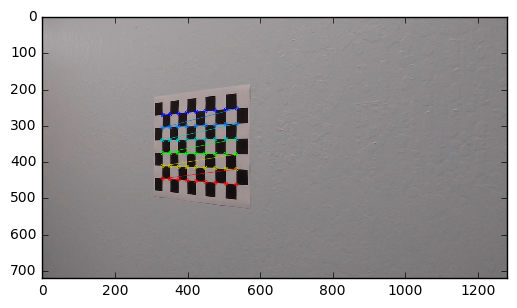

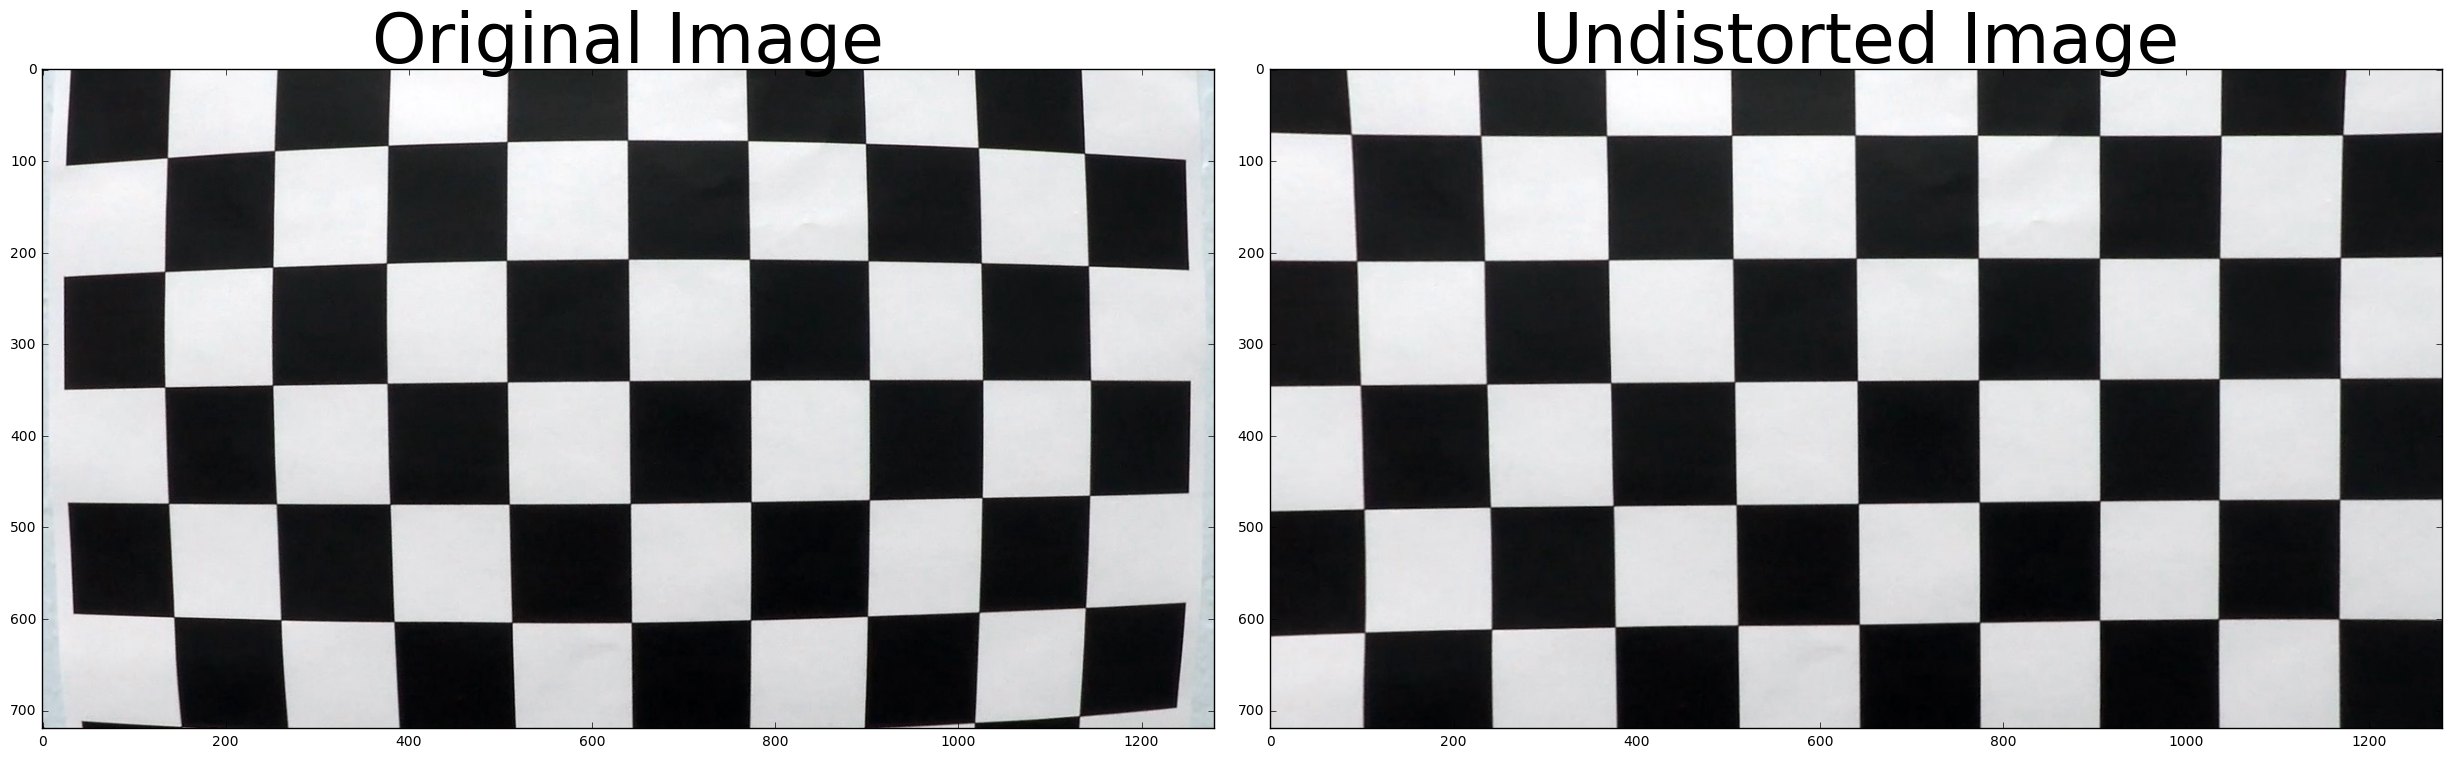

In [117]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

calibration_images_filenames = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
test_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'
show_corners_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration7.jpg'
calibration_images_filenames.remove(test_image_filename)

inside_corners_count_x = 9
inside_corners_count_y = 6

objp = np.zeros((inside_corners_count_x * inside_corners_count_y, 3), np.float32)
objp[:,:2] = np.mgrid[0:inside_corners_count_x, 0:inside_corners_count_y].T.reshape(-1,2)

corners_res = []
objp_res = []

detection_failed_count = 0

for calibration_image_filename in calibration_images_filenames:
    img = cv2.imread(calibration_image_filename)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray_img, (inside_corners_count_x, inside_corners_count_y), None)
    
    if ret:
        corners_res.append(corners)
        objp_res.append(objp)
    else:
        print('Chessboard corner detection failed:', calibration_image_filename)
            
    if show_corners_image_filename == calibration_image_filename:
        img_corners = cv2.drawChessboardCorners(img, (inside_corners_count_x, inside_corners_count_y), corners, ret)
        plt.imshow(img_corners)

test_img = cv2.imread(test_image_filename)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp_res, corners_res, test_img.shape[0:2], None, None)

def undistort(image):
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    return undistorted_img

undistorted_img = undistort(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Binay Image

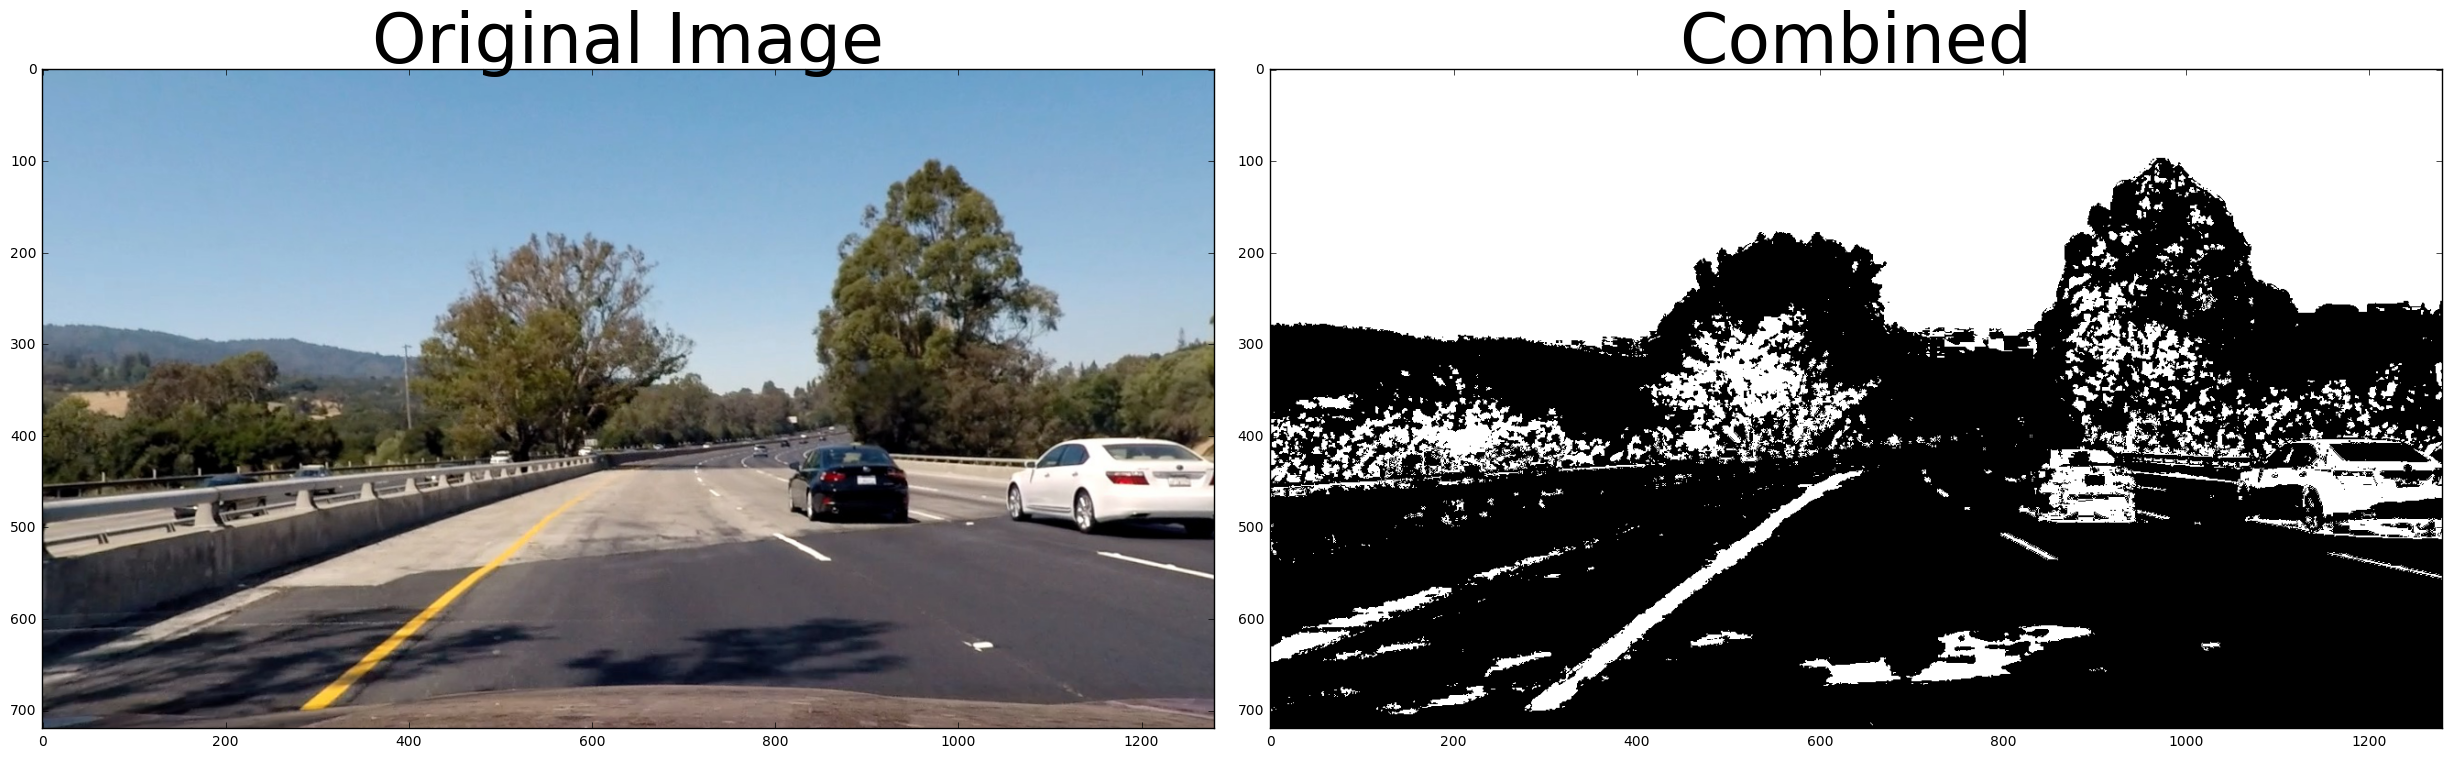

In [118]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    magnitude = np.sqrt(pow(sobel_x, 2) + pow(sobel_y, 2))
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # 6) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 7) Return this mask as your binary_output image
    return sxbinary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def hls_select(S, thresh=(0, 255)):    
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
    
# Read in an image
raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test4.jpg')

def get_binary_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(S, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(S, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(S, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(S, thresh=(90, 255))

    combined = np.zeros_like(dir_binary)
    combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) | (hls_binary == 1)] = 1

    return combined

undistorted_img = undistort(raw_test_image)

combined = get_binary_image(undistorted_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective transform

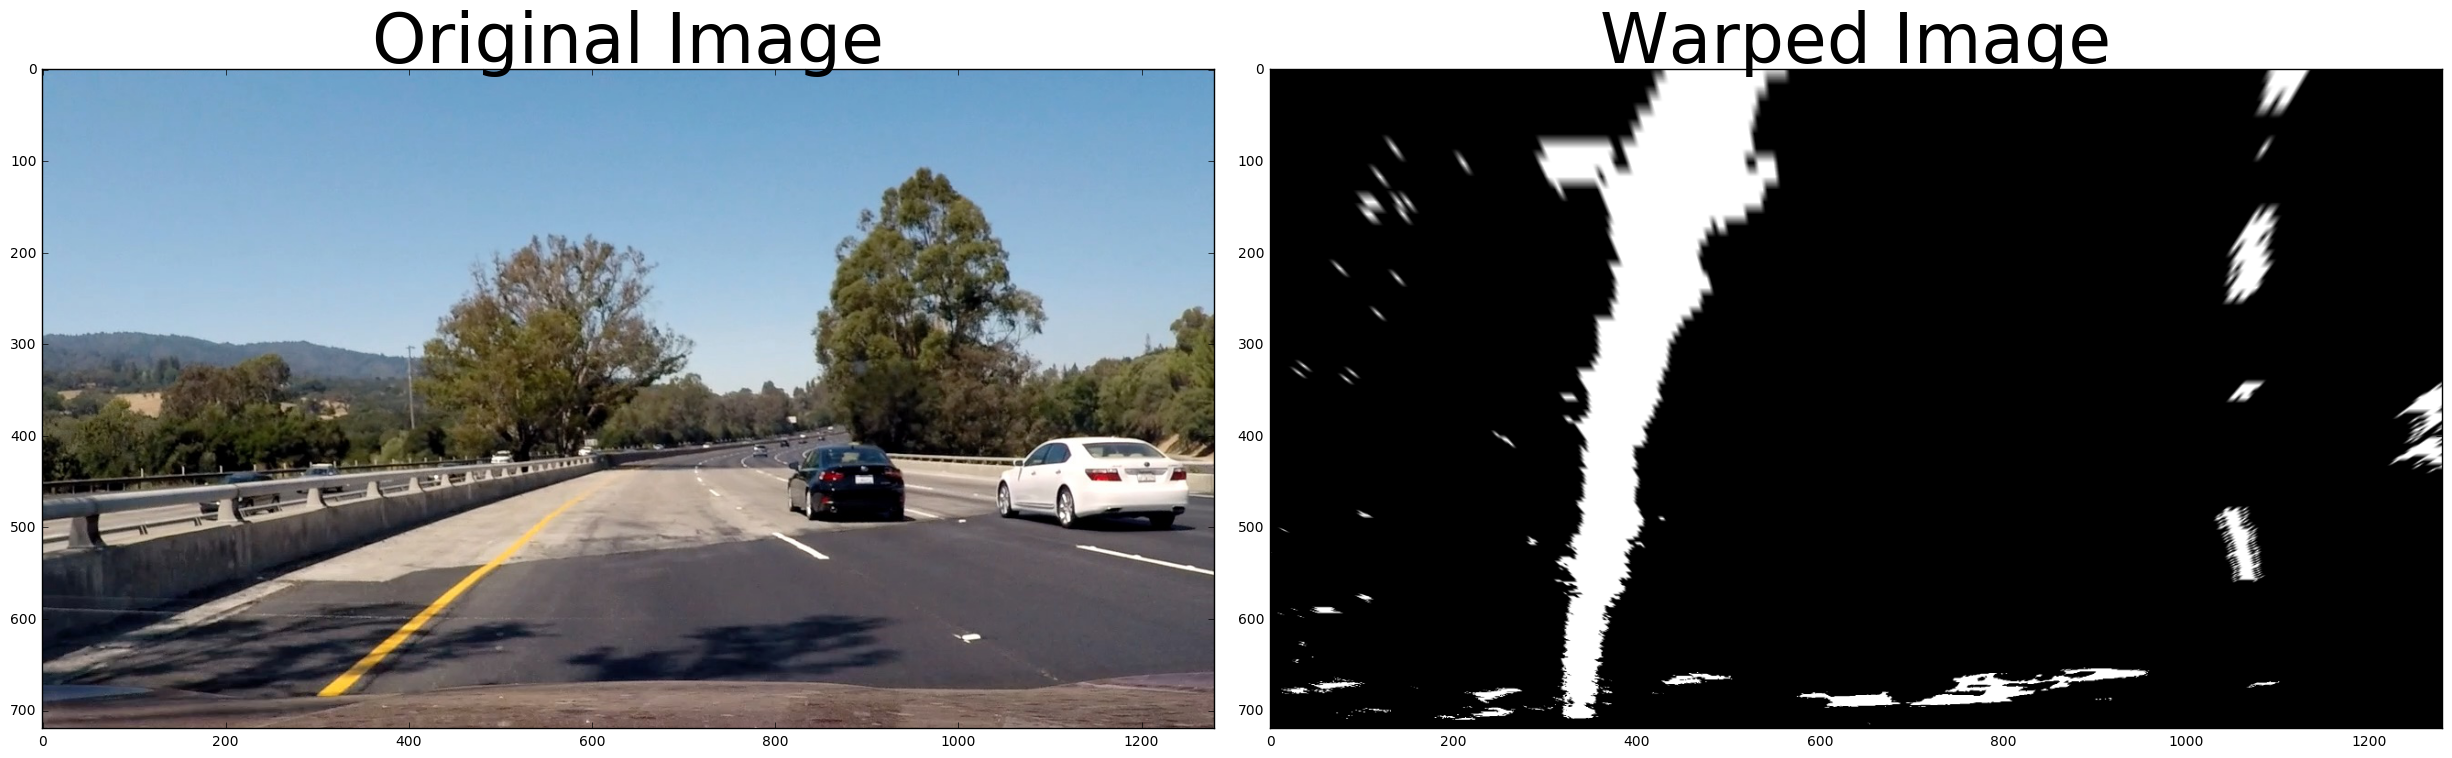

In [143]:
raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test4.jpg')

def changePrespective(image):
    src = np.float32([
            [image.shape[1]*0.45, image.shape[0]*0.625],
            [image.shape[1]*0.55, image.shape[0]*0.625],
            [image.shape[1]*0.175, image.shape[0]*0.95],
            [image.shape[1]*0.825, image.shape[0]*0.95],
        ])

    dst = np.float32([
            [image.shape[1]*0.2,image.shape[0]*0.025],
            [image.shape[1]*0.8,image.shape[0]*0.025],
            [image.shape[1]*0.2,image.shape[0]*0.975],
            [image.shape[1]*0.8,image.shape[0]*0.975],
        ])

    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))

    return warped

undistorted_img = undistort(raw_test_image)

combined = get_binary_image(undistorted_img)

warped = changePrespective(combined)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(raw_test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Finding the lines

//anaconda/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


Left curvature: 1312.393952 m
Right curvature: 1368.86710887 m
Distance from center: 0.0548495293466 m


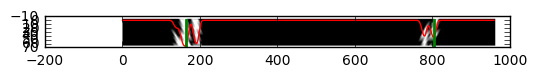

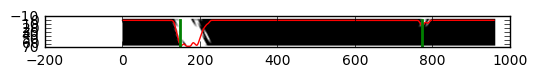

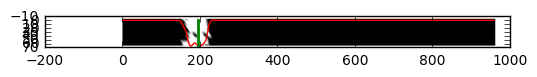

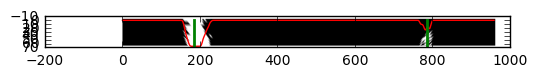

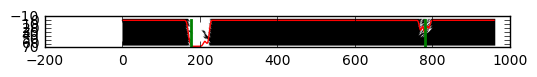

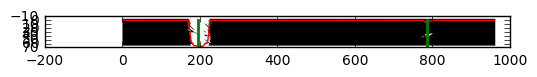

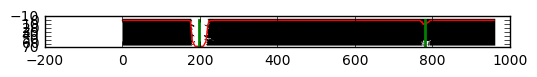

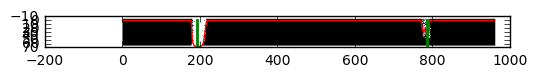

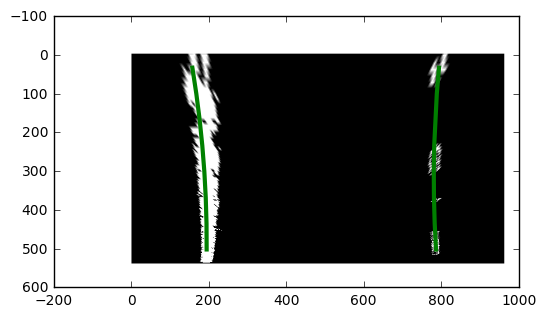

In [236]:
from scipy import signal

raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/solidYellowLeft.jpg')

undistorted_img = undistort(raw_test_image)

combined = get_binary_image(undistorted_img)

warped = changePrespective(combined)

pieces_desired = 8
piece_size = warped.shape[0]//pieces_desired

left_lane_x = []
left_lane_y = []
right_lane_x = []
right_lane_y = []

for i in range(0, pieces_desired):
    low = piece_size * i
    high = piece_size * (i + 1)
    piece = warped[low:high,:]
    histogram = np.sum(piece, axis=0)
    peak_indexes = signal.find_peaks_cwt(histogram, np.arange(1, warped.shape[1]))
    peak_values = [histogram[index] for index in peak_indexes]
    peak_indexes_to_values = {(index, histogram[index]) for index in peak_indexes}
    result = sorted(peak_indexes_to_values, key=lambda index_to_value:index_to_value[1], reverse=True)
    lanes_unsorted = result[:2]
    lanes_index_value = sorted(lanes_unsorted, key=lambda index_to_value:index_to_value[0])
    lanes = []
    if len(result) > 0:
        lanes = np.array(lanes_index_value)[:,:1].reshape(-1)
    if len(lanes) > 0:
        left_lane_x.append(lanes[0])
        left_lane_y.append(low + piece_size // 2)
    if len(lanes) > 1:
        right_lane_x.append(lanes[1])
        right_lane_y.append(low + piece_size // 2)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(piece, cmap='gray')
    ax.plot(histogram, color='red')
    if len(lanes) > 0:
        ax.plot([lanes[0], lanes[0]], [0, piece_size], color='green', linestyle='-', linewidth=2)
    if len(lanes) > 1:
        ax.plot([lanes[1], lanes[1]], [0, piece_size], color='green', linestyle='-', linewidth=2)

left_lane_x = np.array(left_lane_x)
left_lane_y = np.array(left_lane_y)
right_lane_x = np.array(right_lane_x)
right_lane_y = np.array(right_lane_y)

left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
left_fitx = left_fit[0]*left_lane_y**2 + left_fit[1]*left_lane_y + left_fit[2]
right_fit = np.polyfit(right_lane_y, right_lane_x, 2)
right_fitx = right_fit[0]*right_lane_y**2 + right_fit[1]*right_lane_y + right_fit[2]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(warped, cmap='gray')
ax.plot(left_fitx, left_lane_y, color='green', linewidth=3)
ax.plot(right_fitx, right_lane_y, color='green', linewidth=3)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

y_eval = np.max([np.max(left_lane_y), np.max(right_lane_y)])

left_fit_cr = np.polyfit(left_lane_y*ym_per_pix, left_lane_x*xm_per_pix, 2)
right_fit_cr = np.polyfit(right_lane_y*ym_per_pix, right_lane_x*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print("Left curvature:", left_curverad, 'm')
print("Right curvature:", right_curverad, 'm')

left_fitx_bottom_m = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*(y_eval*ym_per_pix) + left_fit_cr[2]
right_fitx_bottom_m = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2]

center_ideal_m = raw_test_image.shape[1]*xm_per_pix / 2
center_actual_m = np.mean([left_fitx_bottom_m, right_fitx_bottom_m])

distance_from_center = abs(center_ideal_m - center_actual_m)
print("Distance from center:", distance_from_center, 'm')